https://github.com/TendTo/Quantum-random-walk-simulation/blob/main/QuantumWalk.ipynb

In [2]:
from pygments.lexers import graphviz
import numpy as np
import networkx as nx
from networkx import hypercube_graph
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
from typing import Callable
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Operator
from qiskit.visualization import circuit_drawer, plot_histogram, plot_bloch_vector
from qiskit_aer import AerSimulator
backend = AerSimulator()
from numpy import pi
import pylatexenc
import graphviz
import pygraphviz


The Bloch sphere is a three-dimensional representation of the qubit state. Operators such as the Pauli-X, Pauli-Y and Pauli-Z operators can be used to rotate the qubit around the Bloch sphere.

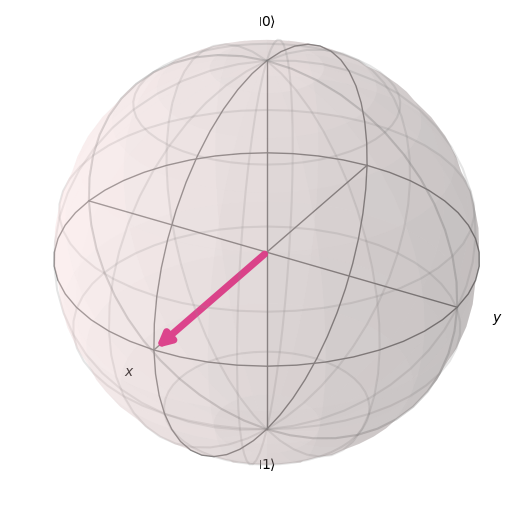

In [3]:
coords = [1, np.pi / 2, 0]  # [Radius, Theta, Phi]
plot_bloch_vector(coords, coord_type="spherical")

When seen in the context of quantum computing, the operators we have seen so far are called quantum gates. They are usually represented by a square that applies the operator to the qubit.

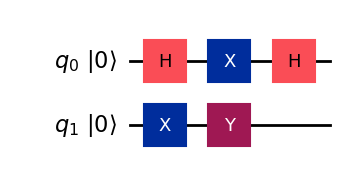

In [4]:
qc = QuantumCircuit(2)
qc.h(0)
qc.x(1)
qc.x(0)
qc.y(1)
qc.h(0)
qc.draw("mpl", initial_state=True)

Controlled gates
Another important building block of quantum circuits are controlled gates. They are gates that are applied to a qubit only if the controlling qubits are in a specific state, usually 
. The controlled-NOT gate is the most common controlled gate, and the corresponding matrix is:

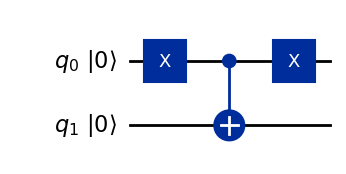

In [5]:
qc = QuantumCircuit(2)
qc.x(0)
qc.cx(0, 1)
qc.x(0)
qc.draw("mpl", initial_state=True)

Classical Markov chains
A Markov chain can be seen as a set of nodes, linked to each other by a probability distribution.
The transition between a node and the following is random and depends only on the probability of the outgoing links of the current node.
This property is called Markovian property.

Markov chain can be further classified as discrete or continuous, depending the times steps. Only discrete Markov chains are considered in this presentation.

Transition matrix
The transition matrix is a square matrix, with the number of rows and columns equal to the number of nodes.
It is used to describe the probability of transition between nodes.

The probability distribution after 
 steps (or at time 
) can be obtained by multiplying the transition matrix by itself 
 times: 
.

An example of a transition matrix could be

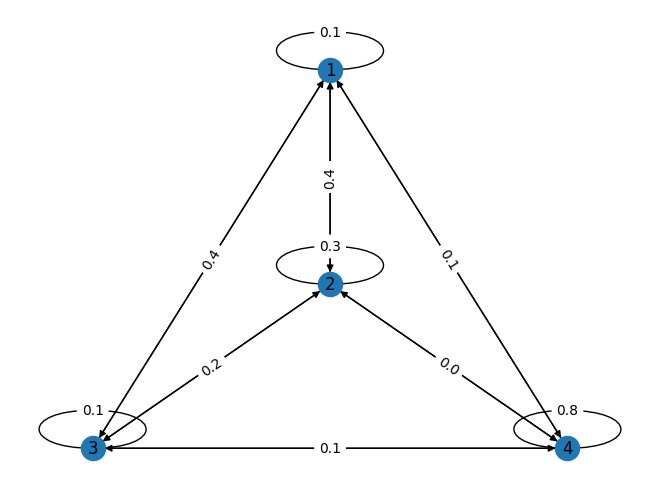

In [6]:
pos = {1: [0.75, 1.0], 2: [0.75, 0.15], 3: [0.5, -0.5], 4: [1.0, -0.5]}
U = [
    [0.1, 0.2, 0.6, 0.1],
    [0.4, 0.3, 0.2, 0.1],
    [0.4, 0.2, 0.1, 0.3],
    [0.1, 0.0, 0.1, 0.8],
]

G = nx.DiGraph(directed=True)
for i in range(1, 5):
    G.add_node(i)
    for j in range(1, 5):
        G.add_edge(i, j, weight=U[i - 1][j - 1])

nx.draw(G, pos=pos, with_labels=True)
nx.draw_networkx_edge_labels(
    G, pos=pos, edge_labels=nx.get_edge_attributes(G, "weight")
)
plt.show()

Quantum walk
Quantum walks are the equivalent to a classical Markov chain.
Due to superposition, a quantum walk can take all possible path simultaneously until the measurement makes the system collapse.
States can be manipulated so that some of them will cancel out, leaving only the desired one.

There are two main models used to implement a quantum walk: coined walk and Szegedy walk. The two models can be equivalent under certain conditions.

Coined walk
A coined walk can be exemplified by a walk over the integer's line. The walker's position is represented with an integer
A coin is used to decide where to move next, left or right.

In [7]:
n_steps = 50  # Number of steps the walker will take
pr = 0.5  # Probability of the walker stepping to the right
initial_position = 0  # Initial position of our walker


def random_walk(pr: float, n_steps: int, initial_pos: int) -> int:
    """Run a random walk with N steps and a probability of stepping to the right of pr.

    Args:
        pr: probability of stepping to the right
        N: number of steps
        i: initial position

    Returns:
        The final position of the walker
    """
    position = initial_pos

    for _ in range(n_steps):
        coin_flip = list(
            np.random.choice(2, 1, p=[1 - pr, pr])
        )  # Flips our weighted coin
        position += 2 * coin_flip[0] - 1  # Moves the walker according to the coin flip

    return position


print(f"The walker is located at: x = {random_walk(pr, n_steps, initial_position)}")

The walker is located at: x = 12


The walker is located at: x = -12
Once plotted, the distribution of such a walk creates the following distribution:

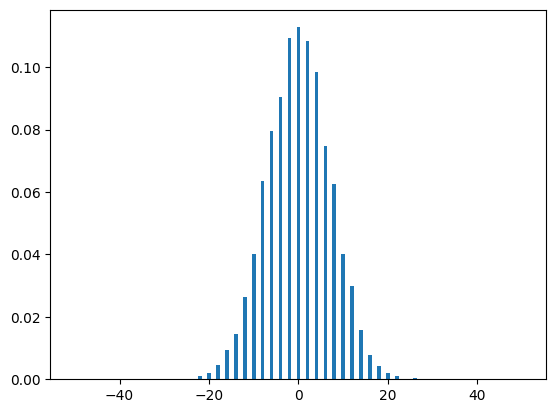

In [8]:
def dist(n_runs: int, n_steps: int):
    """Plot the distribution of the random walk.

    Args:
        runs: number of runs
        N: number of steps
    """
    positions = range(-1 * n_steps, n_steps + 1)
    instances = [0 for _ in range(-1 * n_steps, n_steps + 1)]

    for _ in range(n_runs):
        result = random_walk(pr, n_steps, initial_position)
        instances[positions.index(result)] += 1

    plt.bar(positions, [n / n_runs for n in instances])
    plt.show()


dist(10000, n_steps)

Quantum coin walk
The coin walk algorithm can be translated in a pretty straightforward way to a quantum walk. The position of the walker is encoded in a 
 dimensional space, with 
 possible positions. The resulting Hilbert space is 
, defined as

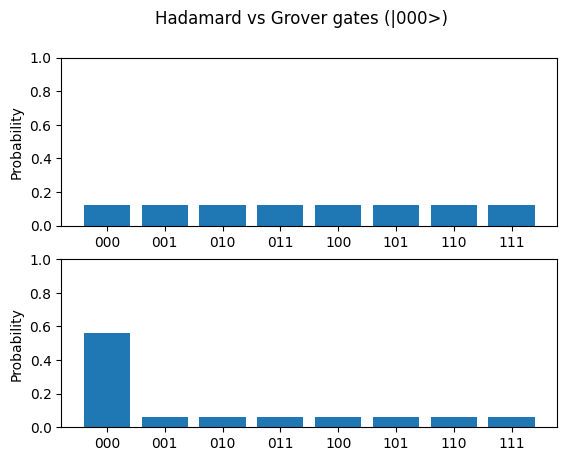

In [9]:
# Number of qubits
n = 3
# Initial state
initial_state = np.array([1] + [0] * (2**n - 1))
assert initial_state.size == 2**n

# Hadamard gate
hadamard_gate_base = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]])
hadamard_gate = hadamard_gate_base
for i in range(n - 1):
    hadamard_gate = np.kron(hadamard_gate, hadamard_gate_base)

# Grover's gate
grover_gate = np.full((2**n, 2**n), 1 / 2 ** (n - 1)) - np.eye(2**n)

# Apply gates
hadamard_res = np.dot(initial_state, hadamard_gate)
hadamard_res = np.square(hadamard_res)
grover_res = np.dot(initial_state, grover_gate)
grover_res = np.square(grover_res)

# Plot results
fig, axes = plt.subplots(2)
plt.suptitle("Hadamard vs Grover gates (|000>)")
for ax, res in zip(axes, [hadamard_res, grover_res]):
    ax.set_ylabel("Probability")
    ax.set_ylim(0, 1)
    ax.bar(tuple(bin(i)[2:].zfill(n) for i in range(res.size)), res)
plt.show()

Quantum coined walk implementation
The implementation of the quantum coined walk will be done using the Qiskit simulator.
The code is inspired by the one found in the Qiskit's Quantum Walk Search Algorithm and Google's Quantum walk examples.

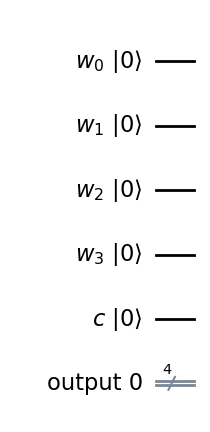

In [10]:
n_walker_qubits = 4  # The number of qubits used to represent the position of the walker


def coined_walk_circuit(
    n_walker_qubits: int,
) -> tuple[QuantumCircuit, QuantumRegister, QuantumRegister, ClassicalRegister]:
    """Create a quantum circuit for the quantum walk.

    Args:
        n_walker_qubits: number of qubits used to represent the position of the walker

    Returns:
        a tuple containing the circuit, the walker qubits, the coin qubits and the classical register to store the output
    """
    walker_r = QuantumRegister(n_walker_qubits, name="w")
    coin_r = QuantumRegister(1, name="c")  # The coin requires only one qubit
    classic_r = ClassicalRegister(n_walker_qubits, name="output")
    qc = QuantumCircuit(walker_r, coin_r, classic_r)
    return qc, walker_r, coin_r, classic_r


qc, _, _, _ = coined_walk_circuit(n_walker_qubits)
qc.draw(output="mpl", initial_state=True)

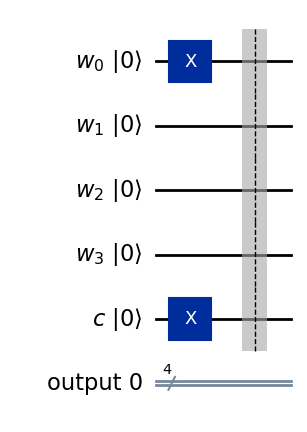

In [11]:
initial_position = 2 ** (
    n_walker_qubits - 1
)  # The initial position of the walker is the middle of all possible positions
initial_coin_value = 1  # The initial value of the coin is 0


def initialize_coined_walk_circuit(
    qc: QuantumCircuit,
    walker_r: QuantumRegister,
    coin_r: QuantumRegister,
    initial_position: int,
    initial_coin_value: int,
) -> QuantumCircuit:
    """Initialize the circuit with the initial position of the walker and the initial value of the coin.

    Args:
        qc: the quantum circuit
        walker_r: the quantum register containing the walker's position qubits
        coin_r: the quantum register containing the coin qubit
        initial_position: the initial position of the walker
        initial_coin_value: the initial value of the coin

    Returns:
        the initialized quantum circuit
    """
    if initial_coin_value == 1:
        qc.x(coin_r)
    for i in range(n_walker_qubits):
        if initial_position & (1 << i):
            qc.x(walker_r[n_walker_qubits - i - 1])
    qc.barrier()
    return qc


qc, walker_r, coin_r, _ = coined_walk_circuit(n_walker_qubits)
qc = initialize_coined_walk_circuit(
    qc, walker_r, coin_r, initial_position, initial_coin_value
)
qc.draw(output="mpl", initial_state=True)

Operators
Coin operator
For the coin operator, the simplest choice is to use the Hadamard gate. When applied to the coin qubit, it will be put in a state of superposition.

Shift operator
The shift operator has to be able to either increment or decrement the walker position, depending on the state of the coin. This can be achieved by using an addition operator, controlled by the coin state.
Since all operators are unitary, once an addition operator A is found, building a corresponding subtraction operator is trivial.

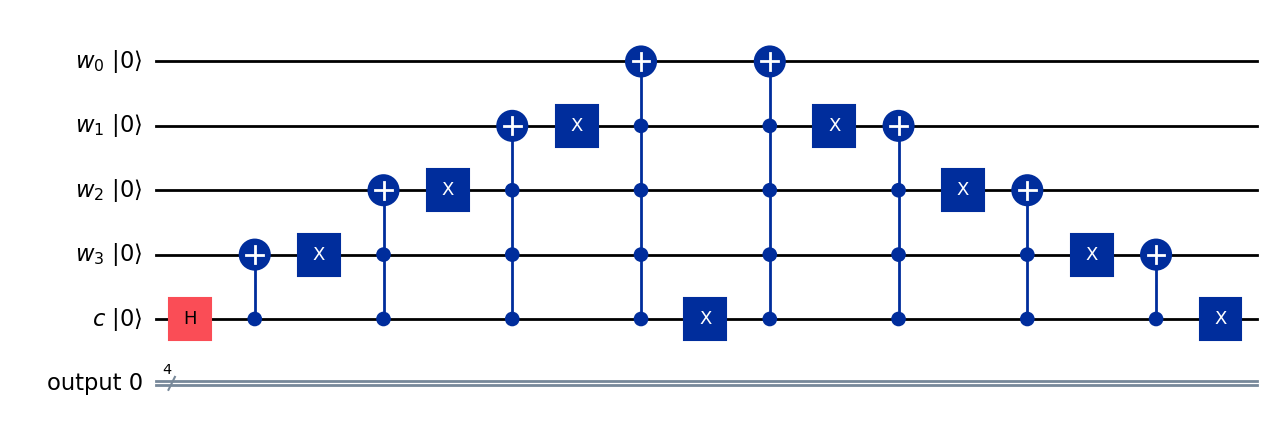

In [12]:
def coined_walk_step(
    qc: QuantumCircuit, walker_r: QuantumRegister, coin_r: QuantumRegister
) -> QuantumCircuit:
    """Single step of the quantum walk.

    Args:
        qc: quantum circuit
        walker_r: the quantum register containing the walker's position qubits
        coin_r: the quantum register containing the coin qubit

    Returns:
        quantum circuit with an added walk step
    """

    # "Flip" the coin vector
    qc.h(coin_r)

    # Implement the Addition Operator
    for i in reversed(range(len(walker_r))):
        # Qubits with less significant bits than the current one
        controls = [walker_r[v] for v in range(len(walker_r) - 1, i, -1)]
        controls.append(coin_r)  # The coin qubit is also used as a control
        qc.mcx(controls, walker_r[i])  # Multi-controlled X gate
        if i != 0:
            qc.x(walker_r[i])  # Flip the qubit

    # Switch the coin vector
    qc.x(coin_r)

    # Implement the Subtraction Operator
    for i in range(len(walker_r)):
        if i != 0:
            qc.x(walker_r[i])  # Reverse the flip
        # Qubits with less significant bits than the current one
        controls = [walker_r[v] for v in range(len(walker_r) - 1, i, -1)]
        controls.append(coin_r)  # The coin qubit is also used as a control
        qc.mcx(controls, walker_r[i])  # Multi-controlled X gate

    # Revert the switch of the coin vector
    qc.x(coin_r)

    return qc


qc, walker_r, coin_r, _ = coined_walk_circuit(n_walker_qubits)
qc = coined_walk_step(qc, walker_r, coin_r)
qc.draw(output="mpl", initial_state=True)

Circuit
With all the operators defined, the circuit can be built by iterating the single step operator as many times as needed. Finally, the walker position is measured and the result is stored in the classical bits.

Mind that we could just take one step at a time and collapse the state of the circuit by measuring it. This would be equivalent to a classical random walk, and would not take advantage of the quantum properties of the system.

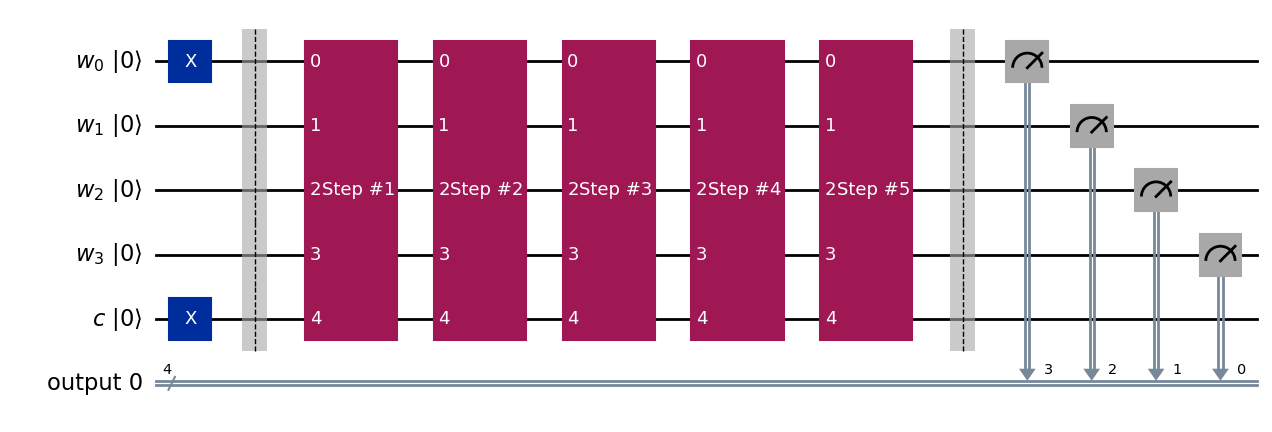

In [13]:
n_steps = 5  # The number of steps of the quantum walk


def coined_walk(
    n_walker_qubits: int,
    n_steps: int,
    initial_position: int,
    initial_coin_value: int,
    init_func: Callable,
) -> QuantumCircuit:
    """Create a quantum circuit for the quantum walk.

    Args:
        n_walker_qubits: number of qubits used to represent the position of the walker
        n_steps: number of steps of the quantum walk
        initial_position: initial position of the walker
        initial_coin_value: initial value of the coin
        init_func: function used to initialize the circuit

    Returns:
        quantum circuit for the quantum walk
    """
    qc, walker_r, coin_r, classic_r = coined_walk_circuit(n_walker_qubits)
    qc = init_func(qc, walker_r, coin_r, initial_position, initial_coin_value)
    for i in range(n_steps):
        step_gate = coined_walk_step(QuantumCircuit(walker_r, coin_r), walker_r, coin_r)
        qc.append(step_gate.to_gate(label=f"Step #{i + 1}"), walker_r[:] + coin_r[:])
    qc.barrier()
    qc.measure(walker_r, reversed(classic_r))
    return qc


qc = coined_walk(
    n_walker_qubits,
    n_steps,
    initial_position,
    initial_coin_value,
    initialize_coined_walk_circuit,
)
qc.draw(output="mpl", initial_state=True)

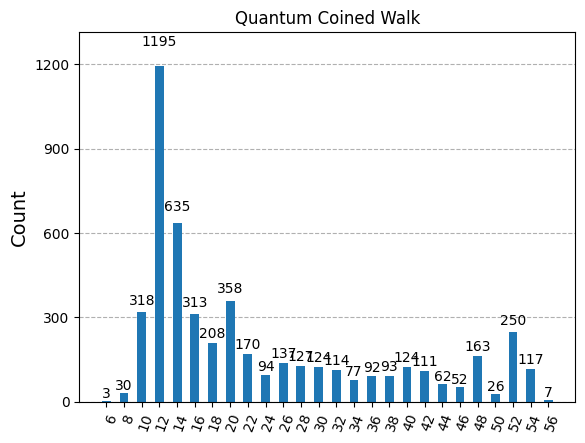

In [14]:
n_walker_qubits = 6  # The number of qubits used to represent the position of the walker
n_steps = 30  # The number of steps of the quantum walk
initial_position = 2 ** (
    n_walker_qubits - 1
)  # The initial position of the walker is the middle of all possible positions
initial_coin_value = 0  # The initial value of the coin is 0
n_runs = 5000  # The number of runs of the quantum circuit

qc = coined_walk(
    n_walker_qubits,
    n_steps,
    initial_position,
    initial_coin_value,
    initialize_coined_walk_circuit,
)


def plot_results(qc: QuantumCircuit, n_runs: int, title: str):
    """Plot the results of the quantum walk.

    Args:
        qc: quantum circuit for the quantum walk
        n_runs: number of runs of the quantum circuit

    Returns:
        histogram of the results of the quantum walk
    """
    simulator = AerSimulator() 
    transpiled_qc = transpile(qc, simulator)
    results = simulator.run(transpiled_qc, shots=n_runs).result()
    counts = results.get_counts(transpiled_qc)
    counts = {int(k, 2): v for k, v in counts.items()}
    return plot_histogram(counts, title=title)


plot_results(qc, n_runs, "Quantum Coined Walk")

Balanced coin
To avoid this bias, why may use another coin, or ensure that the starting state of the coin is equal to 
 
. This can be achieved by applying a Hadamard gate followed by an 
 gate to the coin qubit before starting the walk.
 

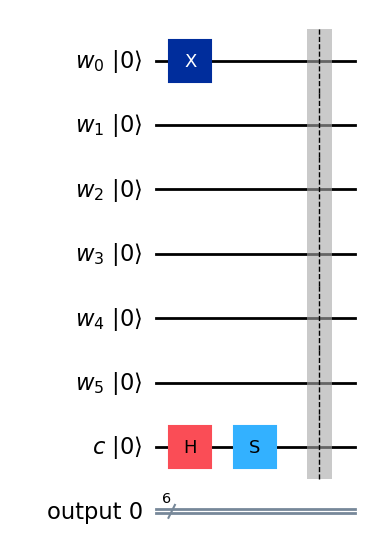

In [15]:
def initialize_balance_coined_walk_circuit(
    qc: QuantumCircuit,
    walker_r: QuantumRegister,
    coin_r: QuantumRegister,
    initial_position: int,
    initial_coin_value: int,
) -> QuantumCircuit:
    """Initialize the circuit with the initial position of the walker and the initial value of the coin.
    Set the coin qubit to |+> and apply the S gate to it to make sure that the coin operator keeps being balanced.

    Args:
        qc: the quantum circuit
        walker_r: the quantum register containing the walker's position qubits
        coin_r: the quantum register containing the coin qubit
        initial_position: the initial position of the walker
        initial_coin_value: the initial value of the coin

    Returns:
        the initialized quantum circuit
    """
    if initial_coin_value == 1:
        qc.x(coin_r)
    qc.h(coin_r)
    qc.s(coin_r)
    for i in range(n_walker_qubits):
        if initial_position & (1 << i):
            qc.x(walker_r[n_walker_qubits - i - 1])
    qc.barrier()
    return qc


qc, walker_r, coin_r, _ = coined_walk_circuit(n_walker_qubits)
qc = initialize_balance_coined_walk_circuit(
    qc, walker_r, coin_r, initial_position, initial_coin_value
)
qc.draw(output="mpl", initial_state=True)

Balanced coin results
Having the coin in this starting state produces results that are more evenly distributed across the graph.


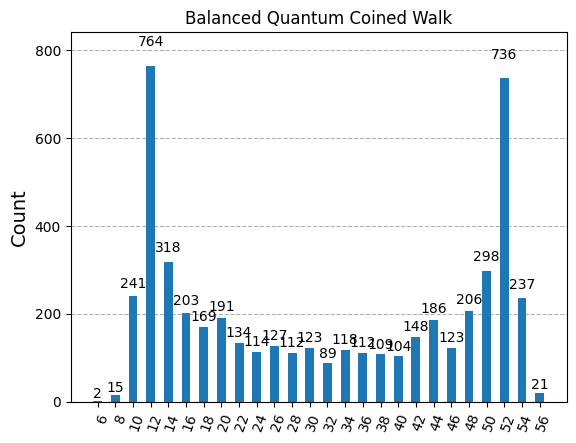

In [16]:
n_walker_qubits = 6  # The number of qubits used to represent the position of the walker
n_steps = 30  # The number of steps of the quantum walk
initial_position = 2 ** (
    n_walker_qubits - 1
)  # The initial position of the walker is the middle of all possible positions
initial_coin_value = 0  # The initial value of the coin is 0
n_runs = 5000  # The number of runs of the quantum circuit

qc = coined_walk(
    n_walker_qubits,
    n_steps,
    initial_position,
    initial_coin_value,
    initialize_balance_coined_walk_circuit,
)

plot_results(qc, n_runs, "Balanced Quantum Coined Walk")


Conclusion
When compared to the classical random walk, it becomes clear that the quantum coined walk results lack the Gaussian properties of the classical random walk. The statistical analysis of its behavior becomes more difficult.

On the other hand, in can be proven that the standard deviation of the distribution, its width, is 
, when the classical counterpart has a standard deviation of 
. The quantum walk travel much further than a classical walk with the same number of steps.
This allows certain problems to be solved more efficiently with a quantum approach, such as Grover's search algorithm.